In [188]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_product, matrix_transpose, rotation_matrix
from astropy.io import fits
import pickle
import scipy.interpolate as scint
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import gala.coordinates as gc
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from astropy_healpix import HEALPix
import time
import os.path
import sys
from scipy.interpolate import interp1d
from PIL import Image
from fpdf import FPDF

In [198]:
class ArbitraryPoleFrame(coord.BaseCoordinateFrame):

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential:[
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    pole = coord.CoordinateAttribute(frame=coord.ICRS)
    roll = coord.QuantityAttribute(default=0*u.degree)


@frame_transform_graph.transform(coord.DynamicMatrixTransform, coord.ICRS, ArbitraryPoleFrame)
def icrs_to_arbpole(icrs_coord, arbpole_frame):

    roll = arbpole_frame.roll
    pole = arbpole_frame.pole

    # Align z(new) with direction to M31
    mat1 = rotation_matrix(-pole.dec, 'y')
    mat2 = rotation_matrix(pole.ra, 'z')
    mat3 = rotation_matrix(roll, 'z')
    mat4 = rotation_matrix(90*u.degree, 'y')
    R = matrix_product(mat4, mat1, mat2, mat3)

    return R


@frame_transform_graph.transform(coord.DynamicMatrixTransform, ArbitraryPoleFrame, coord.ICRS)
def arbpole_to_icrs(arbpole_coord, icrs_frame):
    return matrix_transpose(icrs_to_arbpole(None, arbpole_coord))


def plotFootprint(x, y, filename, nbins=250):
    fig2, axes = plt.subplots()#1, 3, figsize=(15, 5))
    H, xedges, yedges = np.histogram2d(x, y, bins=(nbins, nbins))
    axes.pcolormesh(xedges, yedges, H.T, norm=mpl.colors.LogNorm(vmin=10, vmax=1000))
    plt.ylabel('phi2')
    plt.xlabel('phi1')
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(10,10)
    fig.savefig(filename, rasterized=True)
    return fig2, axes

def plotPMdiff(phi1min, phi1max, filename='sag_pm'):
    minstars = 100.
    minFracBackground = 0.5
    plotSNthreshold = 5.
    detectionThreshold = 5.

    phi1min = phi1min #80*u.deg #-60.*u.deg #105*u.deg
    phi1max = phi1max #120*u.deg #-20.*u.deg #115*u.deg
    phi2min = -0.5*u.deg
    phi2max = 0.5*u.deg

    phi2max_b = 5.0*u.deg
    phi2min_b = 0.5*u.deg

    dphi1 = phi1max - phi1min
    dphi2 = phi2max - phi2min
    dphi2_b = phi2max_b - phi2min_b

    areaSignal = dphi1*dphi2
    areaBackground = (dphi1*dphi2_b)*2.

    dpm1 = 15.#*u.mas/u.yr
    dpm2 = 5.#*u.mas/u.yr
    deltapm = 1.0#*u.mas/u.yr

    deltaphi = 0.1

    signal_edges_pm1 = [-dphi1/2., dphi1/2.]
    signal_edges_pm2 = [-dphi2/2., dphi2/2.]
    background_edges_pm1 = [-dphi1/2., dphi1/2.]
    background_edges_pm2 = [-(dphi2_b + dphi2)/2., -dphi2/2.]
    backgtound_edges_pm2 = [dphi2/2., (dphi2_b+dphi2)/2.]

    signal_indices = (phi1 >= phi1min) & (phi1 <= phi1max) &                      (phi2 >= phi2min) & (phi2 <= phi2max) #& colorCut & magCut

    #check that there are more then 100 stars in the signal sample
    if np.sum(signal_indices) < minstars:
        return None, None
    else:
        background_indices = (phi1 >= phi1min) & (phi1 <= phi1max) &                              np.logical_or((phi2 > phi2min_b) & (phi2 <= phi2max_b),
                                           (phi2 >= -phi2max_b) & (phi2 <= -phi2min_b)) #& colorCut & magCut

        phi1_edges = np.arange(phi1min.value, phi1max.value+000.1, deltaphi)
        phi2_edges = np.arange(-phi2max_b.value, phi2max_b.value+000.1, deltaphi)


        histBack_pos, xe, ye = np.histogram2d(phi1[background_indices].value,
                                              phi2[background_indices].value,
                                              bins=[phi1_edges, phi2_edges])
        frac_back_in_footprint = np.sum(histBack_pos > 0)/np.float(np.sum(histBack_pos >= 0))

        #check that at least some fraction of the background is in the footprint
        if frac_back_in_footprint < minFracBackground:
            return None, None
        else:
            pm1_edges = np.arange(-dpm1, dpm1+0.001, deltapm)
            pm2_edges = np.arange(-dpm2, dpm2+0.001, deltapm)

            H, xedges, yedges = np.histogram2d(pmphi1[signal_indices].value,
                                               pmphi2[signal_indices].value,
                                               bins=[pm1_edges, pm2_edges])
            Hback, xeback, yeback     = np.histogram2d(pmphi1[background_indices].value,
                                               pmphi2[background_indices].value,
                                               bins=[pm1_edges, pm2_edges])

            histSig_pos, xe, ye  = np.histogram2d(phi1[signal_indices].value,
                                                          phi2[signal_indices].value,
                                                          bins=[phi1_edges, phi2_edges])

            ycenters = (yedges[1:] + yedges[:-1])*0.5
            xcenters = (xedges[1:] + xedges[:-1])*0.5
            ybackcenters = (yeback[1:] + yeback[:-1])*0.5


            areaNorm = np.sum(histSig_pos > 0)/np.float(np.sum(histBack_pos > 0))
            finalhist = gaussian_filter(H - Hback*areaNorm, sigma=1.5)
            #finalhist = H - Hback*areaNorm

            H1D = np.sum(H[:,np.abs(ycenters) <= 5], axis=1)
            Hback1D = np.sum(Hback[:,np.abs(ybackcenters) <= 5]*areaNorm, axis=1)

            Hdiff = H1D - Hback1D
            Signal_to_noise = Hdiff/np.sqrt(Hback1D)

            if np.max(Signal_to_noise) > plotSNthreshold:
                fig = plt.figure(figsize=(15, 10))
                ax1 = plt.subplot2grid((4, 2), (0, 0))
                ax2 = plt.subplot2grid((4, 2), (0, 1))
                ax3 = plt.subplot2grid((4, 2), (1, 0))
                ax4 = plt.subplot2grid((4, 2), (1, 1))
                ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
                ax6 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
                plt.suptitle('Fraction of Background in Footprint: {0:0.2f}'.format(frac_back_in_footprint))

                ax6.plot(xcenters, Signal_to_noise, label='S/N')
                ax6.axhline(5, color='black', linestyle='--')
                ax6.set_xlim(-dpm1, dpm1)
                ax6.set_ylim(0,)
                plt.legend()

                blah = ax5.pcolormesh(xedges[::-1], yedges, finalhist.T, vmin=0) #, norm=mpl.colors.LogNorm(vmin=1, vmax=10))
                ax5.set_xlabel('pm1')
                ax5.set_ylabel('pm2')
                ax5.axhline(0.0)

                ax1.hist2d(phi1[signal_indices], phi2[signal_indices], bins=[phi1_edges, phi2_edges])
                ax3.hist2d(phi1[background_indices], phi2[background_indices], bins=[phi1_edges, phi2_edges])

                (counts, xedges, yedges, axis1) = ax2.hist2d(pmphi1[signal_indices], pmphi2[signal_indices],
                                                                bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())
                (counts, xedges, yedges, axis2) = ax4.hist2d(pmphi1[background_indices], pmphi2[background_indices],
                                                                bins=[pm1_edges, pm2_edges], norm=mpl.colors.LogNorm())

                ax2.set_title('signal')
                ax4.set_title('background')
                fig.colorbar(axis1, ax=ax2)
                fig.colorbar(axis2, ax=ax4)

                for axis in [ax1, ax3]:
                    axis.set_xlabel('phi1')
                    axis.set_ylabel('phi2')
                for axis in [ax2, ax4]:
                    axis.set_xlabel('pm1')
                    axis.set_ylabel('pm2')

                plt.tight_layout()
                plt.savefig(filename + '.png', figsize=(10, 15))

            detected = Signal_to_noise >= detectionThreshold
            return xcenters[detected], Signal_to_noise[detected]

In [11]:
dpm1 = 15.#*u.mas/u.yr
dpm2 = 5.#*u.mas/u.yr
deltapm = 1.0#*u.mas/u.yr
pm1_edges = np.arange(-dpm1, dpm1+0.001, deltapm)
pm2_edges = np.arange(-dpm2, dpm2+0.001, deltapm)
print np.shape(pm1_edges), np.shape(pm2_edges)

(31,) (11,)


In [197]:
datafile = 'gaiasdssHaloNew_30b_dustcorrected.pkl'
with open(datafile) as f:
    data = pickle.load(f)

In [4]:
dist = 5
nside = 16
distances = [int(dist)*u.kpc]
print distances[0].value

5.0


In [202]:
xkey = 's_ra1'
ykey = 's_dec1'
pmxkey = 'pmra_new'
pmykey = 'pmdec_new'
lsr = [11.1, 12.1, 7.25]*u.km/u.s
galactic_v = [0.0, 220., 0.0]*u.km/u.s
v_sun = coord.CartesianDifferential(lsr + galactic_v)


#distances = np.arange(5, 21.0001, 5)*u.kpc
phi1left = np.arange(0, 340+000.1, 5)*u.deg #[-50, -45, -40, -35, -30, -25, -20]*u.deg
phi1right = np.arange(20, 360+000.1, 5)*u.deg #[-30, -25, -20, -15, -10, -5, 0]*u.deg


hp = HEALPix(nside=nside, order='ring', frame=coord.Galactic())
centers = hp.healpix_to_skycoord(np.arange(0, hp.npix))
centers = centers[centers.b >= 0.0*u.deg]


detections = {'distance':[],
              'muphi1':[],
              'phi1':[],
              'lpole':[],
              'bpole':[],
              'SN':[]}

NameError: name 'nside' is not defined

In [9]:
filename_pre = 'test'
start = time.clock()
thistime = time.clock()
detected = 0
for distance in distances:
    detectionFilename = 'detections_distance{0:02d}'.format(int(distance.value))
    observed = coord.ICRS(ra=data[xkey]*u.deg, dec=data[ykey]*u.deg,
                          pm_ra_cosdec=data[pmxkey]*u.mas/u.yr, pm_dec=data[pmykey]*u.mas/u.yr,
                          distance=distance)
    #take out sun's motion
    observed = observed.transform_to(coord.Galactic)
    rep = observed.cartesian.without_differentials()
    rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
    observed_nosunv = coord.Galactic(rep)

    for lpole, bpole in zip(centers.l, centers.b):
        print distance, lpole.value, bpole.value, time.clock() - thistime, time.clock()-start
        thistime = time.clock()
        pole = coord.Galactic(l=lpole, b=bpole)
        #print pole
        frame = ArbitraryPoleFrame(pole=pole)
        #align frame with pole
        newframe = observed_nosunv.transform_to(frame)

        pmphi1 = newframe.pm_phi1_cosphi2
        pmphi2 = newframe.pm_phi2
        phi1 = newframe.phi1 #.wrap_at(180*u.deg) #.wrap_at(180*u.deg)
        phi2 = newframe.phi2

        for p1min, p1max in zip(phi1left, phi1right):
            filename = filename_pre+'_dist{0:03d}_pm_{1:03d}_{2:03d}'.format(int(distance.value), int(p1min.value), int(p1max.value))
            muphi1, signal_to_noise = plotPMdiff(p1min, p1max, filename=filename)
            if muphi1 is not None:
                if len(muphi1) > 0:
                    detected += 1
                    #print detections['distance'], distance.value
                    detections['distance'].extend([distance.value]*len(muphi1))
                    detections['muphi1'].extend([muphi1])
                    detections['phi1'].extend([(p1min.value + p1max.value)/2.]*len(muphi1))
                    detections['lpole'].extend([lpole.value]*len(muphi1))
                    detections['bpole'].extend([bpole.value]*len(muphi1))
                    detections['SN'].extend([signal_to_noise])
                    footprint_filename = filename_pre+'_lpole{0:0.2f}_bpole{1:0.2f}_rot.pdf'.format(lpole.value, bpole.value)
                    if not os.path.isfile(footprint_filename):
                        plotFootprint(phi1.value, phi2.value, footprint_filename)
                    if detected % 100 == 0:
                        f = open(detectionFilename,"w")
                        f.write( str(detections) )
                        f.close()
    f = open(detectionFilename,"w")
    f.write( str(detections) )
    f.close()

5.0 kpc 45.0 87.0758196429 61.608862 61.609101
5.0 kpc 135.0 87.0758196429 35.852747 97.461911
5.0 kpc 225.0 87.0758196429 37.596352 135.058314
5.0 kpc 315.0 87.0758196429 36.763563 171.821941
5.0 kpc 22.5 84.1497329363 39.765465 211.587474
5.0 kpc 67.5 84.1497329363 38.838147 250.425675
5.0 kpc 112.5 84.1497329363 37.100771 287.526491
5.0 kpc 157.5 84.1497329363 36.020015 323.546563
5.0 kpc 202.5 84.1497329363 35.878791 359.425433
5.0 kpc 247.5 84.1497329363 37.221394 396.646879
5.0 kpc 292.5 84.1497329363 36.131938 432.778868
5.0 kpc 337.5 84.1497329363 36.825623 469.604551
5.0 kpc 15.0 81.219822316 36.306339 505.911012
5.0 kpc 45.0 81.219822316 37.647789 543.558937
5.0 kpc 75.0 81.219822316 36.099639 579.658638
5.0 kpc 105.0 81.219822316 37.620374 617.279077
5.0 kpc 135.0 81.219822316 42.808973 660.088197
5.0 kpc 165.0 81.219822316 43.055192 703.143489
5.0 kpc 195.0 81.219822316 40.6593 743.80286
5.0 kpc 225.0 81.219822316 40.82973 784.632689
5.0 kpc 255.0 81.219822316 38.397441 823

KeyboardInterrupt: 

In [199]:
distances = [1, 5, 10, 15, 20]
synop = dict()
keys = ['lpole', 'phi1', 'SN', 'bpole', 'muphi1', 'distance'] 
for distance in distances:
    file = 'detections_distance{0:02d}.txt'.format(distance)
    with open(file) as raw_data:
        alldata = raw_data.read()
        blah = alldata.split('\r\n')
        for i in range(6):
            new = blah[i].replace('array', '')
            new = new.replace('[', '')
            new = new.replace(']', '')
            new = new.replace('(', '')
            new = new.replace(')', '')
            new = new.replace('\n', '')
            new = new.replace("'", '')
            new = new.replace('"', '')
            elements = new.split(',')
            key = elements[0]
            arr = np.array(elements[1:])
            arr = arr.astype('float')
            try: synop[key] = np.concatenate((synop[key], arr))
            except KeyError: synop[key] = arr


In [154]:
np.shape(data['distance'])

(24581,)

In [210]:
highSN = (synop['SN'] <= 15) & (synop['SN'] > 12)
print np.sum(highSN)
filename_pre = 'test'
files = []
for distance, lpole, bpole, phi1 in zip(synop['distance'][highSN], synop['lpole'][highSN], synop['bpole'][highSN], synop['phi1'][highSN]):
    p1min = phi1-10
    p1max = phi1+10
    filename = filename_pre+'_dist{0:03d}_lpole{1:0.2f}_bpole{2:0.2f}_phi1{3:03d}_{4:03d}'.format(int(distance), lpole, bpole, int(p1min), int(p1max))
    files.append(filename)
files = np.array(files)
uniqfiles, counts = np.unique(files, return_counts=True)
print len(uniqfiles)


1036
446


In [185]:
lpoles = [image.split('_')[2] for image in uniqfiles]
bpoles = [image.split('_')[3] for image in uniqfiles]

ind = np.argsort(np.array(lpoles))

cover = Image.open('plots/'+uniqfiles[0]+'.png')
width, height = cover.size
pdf = FPDF(unit="pt", format=[width, height+10])
# imagelist is the list with all image filenames
x,y = 0,10
for image in uniqfiles[ind]:
    print image
    pdf.add_page()
    pdf.set_font('Arial', 'B', 14)
    pdf.image('plots/'+image+'.png',x,y)
    pdf.cell(0, txt=image)
pdf.output("highsn.pdf", "F")

test_dist015_lpole109.69_bpole9.59_phi1255_275
test_dist020_lpole109.69_bpole9.59_phi1255_275
test_dist010_lpole109.69_bpole9.59_phi1255_275
test_dist020_lpole115.31_bpole24.62_phi1010_030
test_dist015_lpole115.31_bpole24.62_phi1010_030
test_dist010_lpole115.31_bpole24.62_phi1010_030
test_dist005_lpole115.31_bpole24.62_phi1010_030
test_dist010_lpole118.12_bpole22.02_phi1340_360
test_dist010_lpole118.12_bpole22.02_phi1260_280
test_dist005_lpole118.12_bpole22.02_phi1340_360
test_dist020_lpole118.12_bpole22.02_phi1340_360
test_dist020_lpole118.12_bpole22.02_phi1260_280
test_dist015_lpole118.12_bpole22.02_phi1260_280
test_dist015_lpole118.12_bpole22.02_phi1340_360
test_dist020_lpole120.94_bpole24.62_phi1255_275
test_dist005_lpole120.94_bpole24.62_phi1255_275
test_dist010_lpole120.94_bpole24.62_phi1255_275
test_dist015_lpole120.94_bpole24.62_phi1255_275
test_dist010_lpole123.75_bpole27.28_phi1115_135
test_dist020_lpole123.75_bpole27.28_phi1115_135
test_dist005_lpole123.75_bpole27.28_phi1115

''

In [162]:
for u, c in zip(uniqfiles, counts): print u, c

test_dist001_lpole174.38_bpole2.39_phi1275_295 1
test_dist005_lpole115.31_bpole24.62_phi1010_030 2
test_dist005_lpole118.12_bpole22.02_phi1340_360 3
test_dist005_lpole120.94_bpole24.62_phi1255_275 1
test_dist005_lpole123.75_bpole27.28_phi1115_135 2
test_dist005_lpole126.56_bpole41.81_phi1145_165 2
test_dist005_lpole143.18_bpole57.40_phi1190_210 2
test_dist005_lpole176.54_bpole51.26_phi1095_115 3
test_dist005_lpole176.54_bpole51.26_phi1100_120 1
test_dist005_lpole183.75_bpole54.34_phi1100_120 4
test_dist005_lpole200.45_bpole57.40_phi1100_120 2
test_dist005_lpole233.18_bpole57.40_phi1100_120 3
test_dist005_lpole24.23_bpole51.26_phi1090_110 3
test_dist005_lpole249.55_bpole57.40_phi1115_135 2
test_dist005_lpole33.75_bpole54.34_phi1085_105 6
test_dist005_lpole33.75_bpole54.34_phi1090_110 8
test_dist005_lpole347.73_bpole57.40_phi1220_240 1
test_dist005_lpole355.91_bpole57.40_phi1215_235 1
test_dist005_lpole355.91_bpole57.40_phi1220_240 1
test_dist005_lpole36.82_bpole57.40_phi1080_100 1
test_

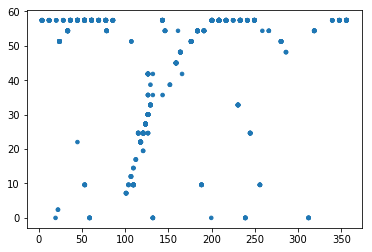

In [212]:
plt.scatter(synop['lpole'][highSN], synop['bpole'][highSN], s=synop['SN'][highSN])

Text(0.5,1,u'pole heat map')

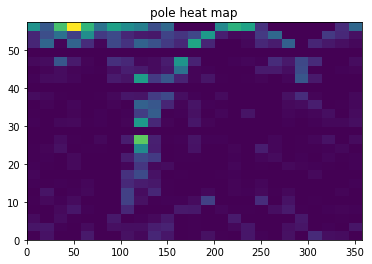

In [214]:
plt.hist2d(synop['lpole'], synop['bpole'], bins=25)
plt.title('pole heat map')

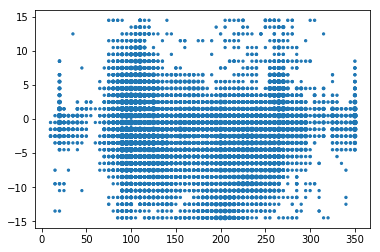

In [213]:
plt.scatter(synop['phi1'], synop['muphi1'], s=synop['SN'])

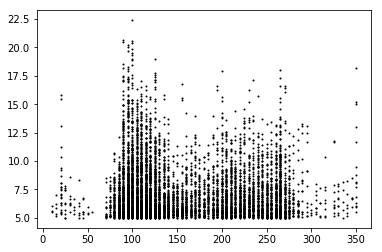

In [137]:
plt.plot(data['phi1'], data['SN'], 'ko', markersize=1)
#plt.xlim(0, 360)
#plt.ylim(0, 20)


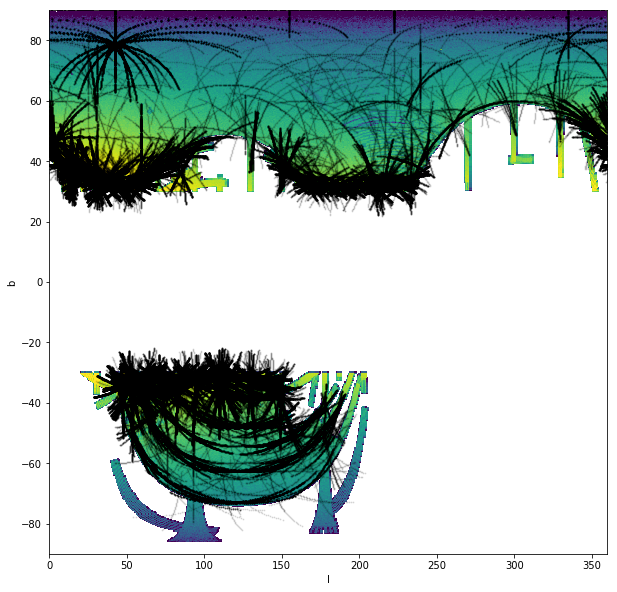

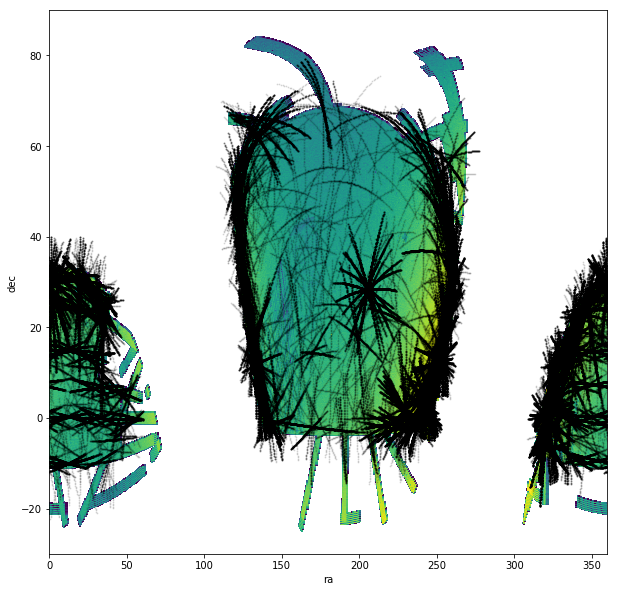

In [231]:
SNindex = (synop['SN'] <= 8) & (synop['SN'] > 5)
figGal, axGal = plotFootprint(data['l'], data['b'], None, nbins=500)
figEq, axEq = plotFootprint(data[xkey], data[ykey], None, nbins=500)
phi1 = np.linspace(0, 360.00001, 1024)
phi2 = np.zeros(len(phi1))
for lpole, bpole, phi1mid in zip(synop['lpole'][SNindex], synop['bpole'][SNindex], synop['phi1'][SNindex]):
    pole = coord.Galactic(l=lpole*u.deg, b=bpole*u.deg)
    index = (phi1 <= phi1mid+10) & (phi1 >= phi1mid-10)
    testobserved = ArbitraryPoleFrame(phi1=phi1[index]*u.deg, phi2=phi2[index]*u.deg, pole=pole)
    gal = testobserved.transform_to(coord.Galactic)
    eq = testobserved.transform_to(coord.ICRS)
    axGal.scatter(gal.l, gal.b, s=1, alpha=0.1, c='black')
    axEq.scatter(eq.ra, eq.dec, s=1, alpha=0.1, c='black')
for ax in [axGal, axEq]: ax.set_xlim(0, 360)
axGal.set_ylim(-90, 90)
axGal.set_xlabel('l')
axGal.set_ylabel('b')
axEq.set_ylim(-30, 90)
axEq.set_xlabel('ra')
axEq.set_ylabel('dec')
figGal.savefig('SNgalview_5to8.png')
figEq.savefig('SNeqview_5to8.png')

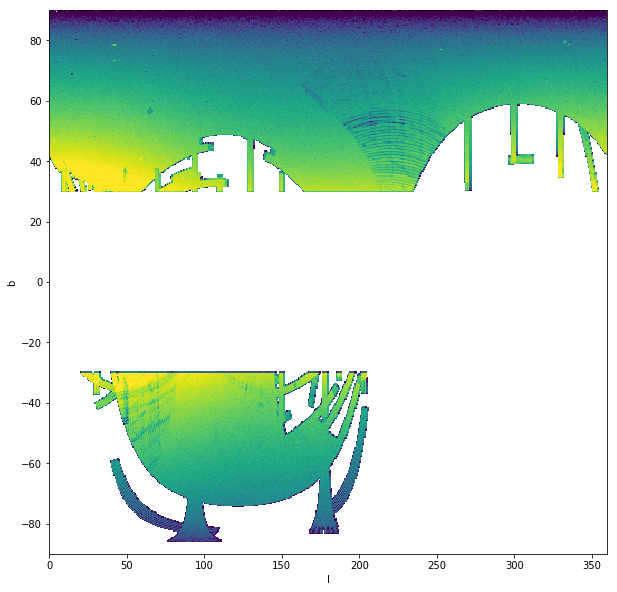

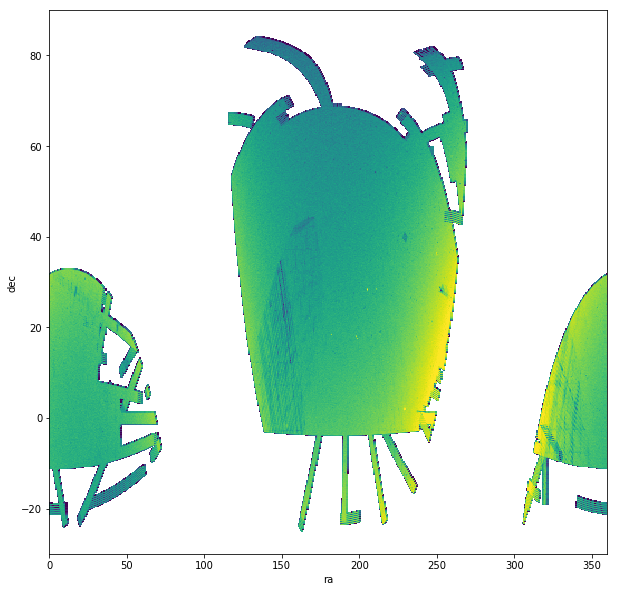

In [229]:
figGal, axGal = plotFootprint(data['l'], data['b'], None, nbins=500)
figEq, axEq = plotFootprint(data[xkey], data[ykey], None, nbins=500)
axGal.set_ylim(-90, 90)
axGal.set_xlabel('l')
axGal.set_ylabel('b')
axEq.set_ylim(-30, 90)
axEq.set_xlabel('ra')
axEq.set_ylabel('dec')

figGal.savefig('galview.png')
figEq.savefig('eqview.png')